# Traffic Data Analysis and Prediction


## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [2]:
# Display only top 5 and bottom 5 rows
pd.set_option('display.max_rows', 10)

In [3]:
df_train = pd.read_csv("data/train128.csv", parse_dates=[0], infer_datetime_format=True)
df_test = pd.read_csv("data/test128.csv", parse_dates=[0], infer_datetime_format=True)


print("Size of training set: " + str(df_train.shape))
print("Size of testing set:  " + str(df_test.shape))

print("")

print('Columns in train: ' + str(df_train.columns.tolist()))
print('Columns in test:  '  + str(df_test.columns.tolist()))

Size of training set: (48120, 4)
Size of testing set:  (11808, 3)

Columns in train: ['DateTime', 'Junction', 'Vehicles', 'ID']
Columns in test:  ['DateTime', 'Junction', 'ID']


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 4 columns):
DateTime    48120 non-null datetime64[ns]
Junction    48120 non-null int64
Vehicles    48120 non-null int64
ID          48120 non-null int64
dtypes: datetime64[ns](1), int64(3)
memory usage: 1.5 MB


In [5]:
df_train.describe()

,Junction,Vehicles,ID
count,48120.000000,48120.000000,4.812000e+04
mean,2.180549,22.791334,2.016330e+10
std,0.966955,20.750063,5.944854e+06
min,1.000000,1.000000,2.015110e+10
25%,1.000000,9.000000,2.016042e+10
50%,2.000000,15.000000,2.016093e+10
75%,3.000000,29.000000,2.017023e+10
max,4.000000,180.000000,2.017063e+10


In [6]:
#Setting the size and grid for plotting
sns.set(rc= {"figure.figsize": (10, 8)})

C:\Users\Samyak\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\Samyak\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


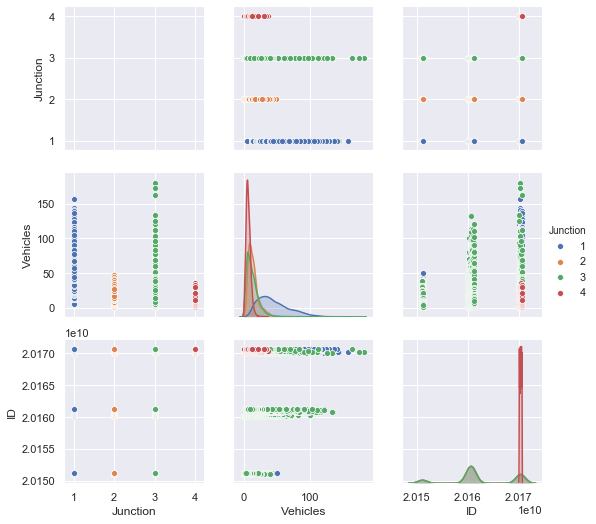

In [7]:
sns.pairplot(df_train, hue="Junction")

### Distribution of junctions and vehicles

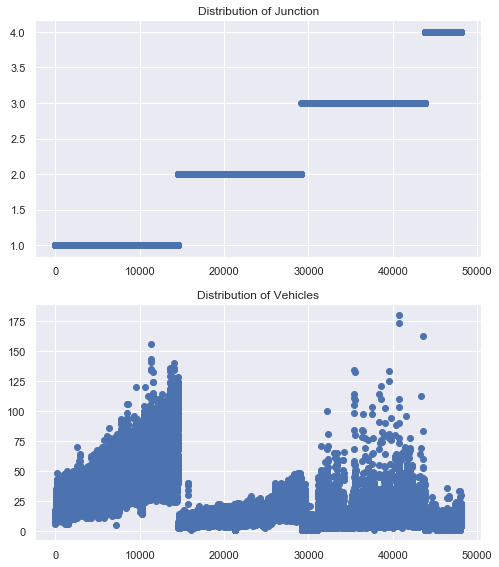

In [8]:
cols_to_use = ['Junction', 'Vehicles']
fig = plt.figure(figsize=(8, 20))
plot_count = 0
for col in cols_to_use:
    plot_count += 1
    plt.subplot(4, 1, plot_count)
    plt.scatter(range(df_train.shape[0]), df_train[col].values)
    plt.title("Distribution of "+col)
plt.show()

In [9]:
# Checking Indexing
for i in range(1, 5):
    print(df_train[df_train.Junction==i].head())

             DateTime  Junction  Vehicles           ID
0 2015-11-01 00:00:00         1        15  20151101001
1 2015-11-01 01:00:00         1        13  20151101011
2 2015-11-01 02:00:00         1        10  20151101021
3 2015-11-01 03:00:00         1         7  20151101031
4 2015-11-01 04:00:00         1         9  20151101041
                 DateTime  Junction  Vehicles           ID
14592 2015-11-01 00:00:00         2         6  20151101002
14593 2015-11-01 01:00:00         2         6  20151101012
14594 2015-11-01 02:00:00         2         5  20151101022
14595 2015-11-01 03:00:00         2         6  20151101032
14596 2015-11-01 04:00:00         2         7  20151101042
                 DateTime  Junction  Vehicles           ID
29184 2015-11-01 00:00:00         3         9  20151101003
29185 2015-11-01 01:00:00         3         7  20151101013
29186 2015-11-01 02:00:00         3         5  20151101023
29187 2015-11-01 03:00:00         3         1  20151101033
29188 2015-11-01 04:0

## EDA

In [10]:
df_tmp = df_train.set_index(['Junction', 'DateTime'])

In [11]:
level_values = df_tmp.index.get_level_values
level_values(0)

Int64Index([1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
            ...
            4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
           dtype='int64', name='Junction', length=48120)

# Feature engineering

## 1. Convert each junction as a column
We actually have 4 predictions to do, one per junction

In [12]:
train = df_train.pivot(index='DateTime',columns='Junction', values='Vehicles')
train

Junction,1,2,3,4
DateTime,,,,
2015-11-01 00:00:00,15.0,6.0,9.0,NaN
2015-11-01 01:00:00,13.0,6.0,7.0,NaN
2015-11-01 02:00:00,10.0,5.0,5.0,NaN
2015-11-01 03:00:00,7.0,6.0,1.0,NaN
2015-11-01 04:00:00,9.0,7.0,2.0,NaN
...,...,...,...,...
2017-06-30 19:00:00,105.0,34.0,33.0,11.0
2017-06-30 20:00:00,96.0,35.0,31.0,30.0
2017-06-30 21:00:00,90.0,31.0,28.0,16.0


#### Fill NaNs with 0 vehicles

In [13]:
train = train.fillna(0)

## 2. Generate lag features

In [14]:
def gen_lag_features(df, n_in=1, n_out=1, dropnan=True):
    """
    Arguments:
        data: Dataframe of observations.
        n_in: Number of lag observations as input (X).
        n_out: Number of forecast observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Dataframe.
    """
    n_vars = df.shape[1]
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('Junction %d (H-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('Junction %d (H)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('Junction %d (H+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [15]:
Xy_train = gen_lag_features(train)
Xy_train

,Junction 1 (H-1),Junction 2 (H-1),Junction 3 (H-1),Junction 4 (H-1),Junction 1 (H),Junction 2 (H),Junction 3 (H),Junction 4 (H)
DateTime,,,,,,,,
2015-11-01 01:00:00,15.0,6.0,9.0,0.0,13.0,6.0,7.0,0.0
2015-11-01 02:00:00,13.0,6.0,7.0,0.0,10.0,5.0,5.0,0.0
2015-11-01 03:00:00,10.0,5.0,5.0,0.0,7.0,6.0,1.0,0.0
2015-11-01 04:00:00,7.0,6.0,1.0,0.0,9.0,7.0,2.0,0.0
2015-11-01 05:00:00,9.0,7.0,2.0,0.0,6.0,2.0,2.0,0.0
...,...,...,...,...,...,...,...,...
2017-06-30 19:00:00,95.0,34.0,38.0,17.0,105.0,34.0,33.0,11.0
2017-06-30 20:00:00,105.0,34.0,33.0,11.0,96.0,35.0,31.0,30.0
2017-06-30 21:00:00,96.0,35.0,31.0,30.0,90.0,31.0,28.0,16.0


## Normalize features

In [16]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [17]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [18]:
Xy_train[Xy_train.columns] = scaler.fit_transform(Xy_train[Xy_train.columns])
Xy_train

,Junction 1 (H-1),Junction 2 (H-1),Junction 3 (H-1),Junction 4 (H-1),Junction 1 (H),Junction 2 (H),Junction 3 (H),Junction 4 (H)
DateTime,,,,,,,,
2015-11-01 01:00:00,0.066225,0.106383,0.044693,0.000000,0.052980,0.106383,0.033520,0.000000
2015-11-01 02:00:00,0.052980,0.106383,0.033520,0.000000,0.033113,0.085106,0.022346,0.000000
2015-11-01 03:00:00,0.033113,0.085106,0.022346,0.000000,0.013245,0.106383,0.000000,0.000000
2015-11-01 04:00:00,0.013245,0.106383,0.000000,0.000000,0.026490,0.127660,0.005587,0.000000
2015-11-01 05:00:00,0.026490,0.127660,0.005587,0.000000,0.006623,0.021277,0.005587,0.000000
...,...,...,...,...,...,...,...,...
2017-06-30 19:00:00,0.596026,0.702128,0.206704,0.472222,0.662252,0.702128,0.178771,0.305556
2017-06-30 20:00:00,0.662252,0.702128,0.178771,0.305556,0.602649,0.723404,0.167598,0.833333
2017-06-30 21:00:00,0.602649,0.723404,0.167598,0.833333,0.562914,0.638298,0.150838,0.444444


## Split train and valid (and normalize for real)

In [19]:
X_train = Xy_train[Xy_train.index < '2017-04-01'].iloc[:,0:4]
X_train

,Junction 1 (H-1),Junction 2 (H-1),Junction 3 (H-1),Junction 4 (H-1)
DateTime,,,,
2015-11-01 01:00:00,0.066225,0.106383,0.044693,0.000000
2015-11-01 02:00:00,0.052980,0.106383,0.033520,0.000000
2015-11-01 03:00:00,0.033113,0.085106,0.022346,0.000000
2015-11-01 04:00:00,0.013245,0.106383,0.000000,0.000000
2015-11-01 05:00:00,0.026490,0.127660,0.005587,0.000000
...,...,...,...,...
2017-03-31 19:00:00,0.476821,0.574468,0.178771,0.166667
2017-03-31 20:00:00,0.496689,0.531915,0.156425,0.222222
2017-03-31 21:00:00,0.483444,0.638298,0.156425,0.222222


In [20]:
y_train = Xy_train[Xy_train.index < '2017-04-01'].iloc[:,4:]
y_train

,Junction 1 (H),Junction 2 (H),Junction 3 (H),Junction 4 (H)
DateTime,,,,
2015-11-01 01:00:00,0.052980,0.106383,0.033520,0.000000
2015-11-01 02:00:00,0.033113,0.085106,0.022346,0.000000
2015-11-01 03:00:00,0.013245,0.106383,0.000000,0.000000
2015-11-01 04:00:00,0.026490,0.127660,0.005587,0.000000
2015-11-01 05:00:00,0.006623,0.021277,0.005587,0.000000
...,...,...,...,...
2017-03-31 19:00:00,0.496689,0.531915,0.156425,0.222222
2017-03-31 20:00:00,0.483444,0.638298,0.156425,0.222222
2017-03-31 21:00:00,0.403974,0.574468,0.150838,0.250000


## Reshape the Data

We have the following dimensions:
(Batch_size, junctions, features) with Batch_size = 12407, junctions = 4, features = 1

junctions can be thought as "Colors" and "channels" in image predictions

In [21]:
X_train = np.expand_dims(X_train.values, axis=2)
print(X_train.shape)

y_train = y_train.values
print(y_train.shape)

(12407, 4, 1)
(12407, 4)


# Defining and training a model

In [22]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.initializers import he_normal
import tensorflow.compat.v1 as tf

Using TensorFlow backend.


In [23]:
import keras.backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

In [24]:
# Initialising the RNN
regressor = Sequential()

# Adding the input layer and the LSTM layer
regressor.add(LSTM(units = 50,
                   activation = 'relu', # default is tanh
                   kernel_initializer = he_normal(seed=0),
                   input_shape = (None, 1)))

# Output for 4 junctions
regressor.add(Dense(units = 4))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = root_mean_squared_error)

In [25]:
# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, batch_size = 50, epochs = 200, verbose = 1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/200





12407/12407 [==============================] - 4s 297us/step - loss: 0.0489
Epoch 2/200
12407/12407 [==============================] - 2s 123us/step - loss: 0.0364
Epoch 3/200
12407/12407 [==============================] - 3s 215us/step - loss: 0.0342
Epoch 4/200
12407/12407 [==============================] - 3s 252us/step - loss: 0.0334
Epoch 5/200
12407/12407 [==============================] - 3s 246us/step - loss: 0.0332
Epoch 6/200
12407/12407 [==============================] - 3s 242us/step - loss: 0.0329
Epoch 7/200
12407/12407 [==============================] - 3s 244us/step - loss: 0.0327
Epoch 8/200
12407/12407 [==============================] - 3s 244us/step - loss: 0.0327
Epoch 9/200
12407/12407 [==============================] - 3s 245us/step - loss: 0.0326
Epoch 10/200
12407/12407 [==============================] - 3s 245us/step - loss: 0.0325
Epoch 11/200
1240

12407/12407 [==============================] - 4s 302us/step - loss: 0.0312 1s - lo - 
Epoch 157/200
12407/12407 [==============================] - 4s 299us/step - loss: 0.0312
Epoch 158/200
12407/12407 [==============================] - 4s 301us/step - loss: 0.0313 3s - loss:  - ETA: 2s -  - ETA: 1s - loss - ETA: 1s - loss: - ETA: 1s - loss: 0.031 - ETA: 
Epoch 159/200
12407/12407 [==============================] - 4s 302us/step - loss: 0.0312
Epoch 160/200
12407/12407 [==============================] - 4s 304us/step - loss: 0.0312
Epoch 161/200
12407/12407 [==============================] - 4s 303us/step - loss: 0.0312 1s - los
Epoch 162/200
12407/12407 [==============================] - 4s 307us/step - loss: 0.0312 0s - los
Epoch 163/200
12407/12407 [==============================] - 4s 307us/step - loss: 0.0312  - ET
Epoch 164/200
12407/12407 [==============================] - 4s 307us/step - loss: 0.0312 2s - los - ETA: 1s - loss: 0.031 - ETA: 0s - loss: 0.031
Epoch 165/200
12407/

# Validate

In [26]:
X_valid = Xy_train[Xy_train.index >= '2017-04-01'].iloc[:,0:4]
X_valid

,Junction 1 (H-1),Junction 2 (H-1),Junction 3 (H-1),Junction 4 (H-1)
DateTime,,,,
2017-04-01 00:00:00,0.417219,0.553191,0.162011,0.166667
2017-04-01 01:00:00,0.384106,0.510638,0.122905,0.166667
2017-04-01 02:00:00,0.317881,0.574468,0.078212,0.138889
2017-04-01 03:00:00,0.238411,0.361702,0.083799,0.111111
2017-04-01 04:00:00,0.225166,0.361702,0.055866,0.111111
...,...,...,...,...
2017-06-30 19:00:00,0.596026,0.702128,0.206704,0.472222
2017-06-30 20:00:00,0.662252,0.702128,0.178771,0.305556
2017-06-30 21:00:00,0.602649,0.723404,0.167598,0.833333


In [27]:
X_valid = np.expand_dims(X_valid.values, axis=2)

In [28]:
y_pred = regressor.predict(X_valid)

In [29]:
# We rescale y in the integer count range
# To do that we must first reconcatenate with the X data as scaler expects a shape of 8
y_pred = scaler.inverse_transform(np.concatenate((X_valid.squeeze(), y_pred), axis = 1))[:, 4:]
y_pred

array([[ 68.1297293 ,  24.78367722,  26.04579669,   7.60507751],
       [ 62.73615921,  23.02693582,  19.98123485,   6.92939472],
       [ 49.28488931,  22.33989638,  12.13200466,   4.8950513 ],
       ...,
       [101.27726769,  32.32616544,  27.3957132 ,  23.80310082],
       [ 87.37686926,  28.40995073,  26.26324363,  12.49124908],
       [ 84.14015388,  26.35000062,  22.40192875,  16.49629569]])

In [30]:
y_truth = train[train.index >= '2017-04-01']
y_truth

Junction,1,2,3,4
DateTime,,,,
2017-04-01 00:00:00,63.0,25.0,23.0,6.0
2017-04-01 01:00:00,53.0,28.0,15.0,5.0
2017-04-01 02:00:00,41.0,18.0,16.0,4.0
2017-04-01 03:00:00,39.0,18.0,11.0,4.0
2017-04-01 04:00:00,31.0,15.0,10.0,1.0
...,...,...,...,...
2017-06-30 19:00:00,105.0,34.0,33.0,11.0
2017-06-30 20:00:00,96.0,35.0,31.0,30.0
2017-06-30 21:00:00,90.0,31.0,28.0,16.0


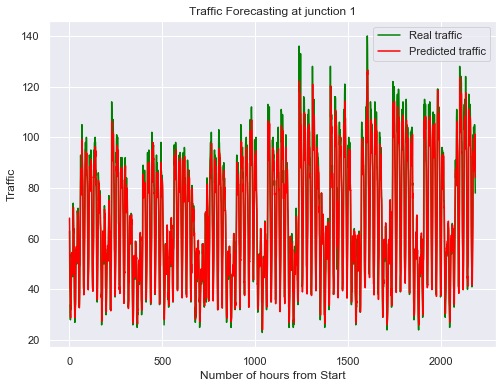

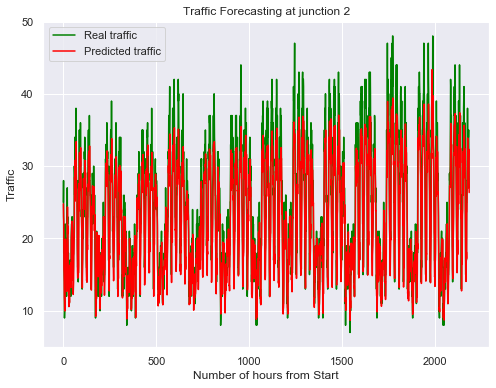

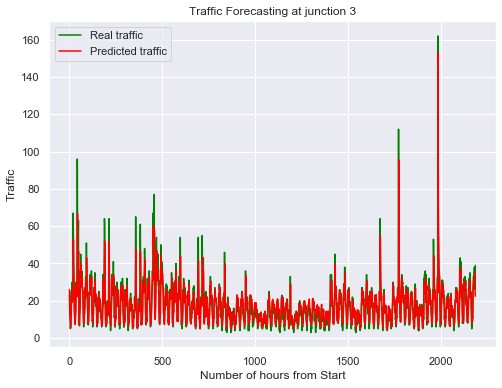

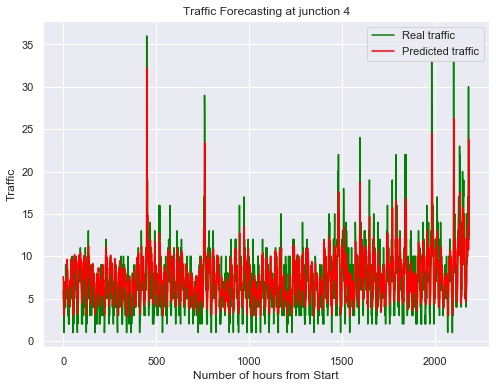

In [31]:
# Visualising Result for the junctions
sns.set(rc= {"figure.figsize": (8, 6)})
for junction in range(4):
    plt.figure
    plt.plot(y_truth.values[:,junction], color = 'green', label = 'Real traffic')
    plt.plot(y_pred[:,junction], color = 'red', label = 'Predicted traffic')
    plt.title('Traffic Forecasting at junction %i' % (junction+1))
    plt.xlabel('Number of hours from Start')
    plt.ylabel('Traffic')
    plt.legend()
    plt.show()

In [32]:
from sklearn.metrics import mean_squared_error
from math import sqrt

def rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

In [33]:
rmse(y_truth, y_pred)

5.76912041149199

# Predictions
For predictions we will have to do a different pipeline since we don't have the previous hour traffic like in validation.

- We predict step by step and previous prediction is input of the next one
- We create 6 months min lag features
- We predict 4 months of traffic at each point (Rolling forecast)

# Rolling Forecast Predictions

In [34]:
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.initializers import he_normal
%matplotlib inline

In [35]:
# Set random seed for reproducibility
# Note: CuDNN is usually non-deterministic
# (can't determine which of the ~3000 threads finish earlier)
# And floating points reduction is not perfectly associative due to ULP rounding
import numpy as np
np.random.seed(1337)
import tensorflow as tf
tf.set_random_seed(1337)

In [36]:
nb_forecast_per_junction = 24 * (31 + 31 + 30 + 31) # Days in jul + aug + sep + oct

In [37]:
nb_forecast_per_junction

2952

In [38]:
nb_forecast_per_junction * 4

11808

That will certainly not fit in the GPU VRAM --> We will get inspiration from seq2seq models and do a sliding window of time that matches a week.

In [39]:
num_feats = 4
seq_len = 24 * 2 # We predict 48 hours
num_outputs = 4
num_hidden = 4 # We keep 8 days of state
bs = 128
epochs = 500
LOG_PATH = "checkpoints/" + time.strftime("%Y-%m-%d_%H%M-")+"s2s-concat-Conv1d.hdf5"

# pred_len = int(nb_forecast_per_junction / seq_len)
# assert nb_forecast_per_junction % seq_len == 0 # Check that we can split forecast into even sequences
# print(pred_len)

We originally had 14592 rows, we will generate sequences of predictions from it.

In [40]:
def make_input_seqs(data, seq_len, train_split=0.9):
    seq_len = seq_len + 1
    result = []
    for index in range(len(data) - seq_len):
        result.append(data[index: index + seq_len, :])
    result = np.array(result) # shape (14423, 168, 4)
    train_ind = round(train_split * result.shape[0])
    train = result[:int(train_ind), :, :]
    x_train = train[:, :-1, :]
    y_train = train[:, -1, :]
    x_test = result[int(train_ind):, :-1, :]
    y_test = result[int(train_ind):, -1, :]

    return [x_train, y_train, x_test, y_test]

In [41]:
X_train, y_train, X_test, y_test = make_input_seqs(train.values, seq_len)

# Generate model

## Neural Network

In [42]:
from keras.optimizers import adam, rmsprop, sgd
from keras.layers import *
from keras.layers.core import *
from keras.layers.recurrent import *
from keras.models import *
from keras.activations import *

### Optimizer

In [43]:
adam = adam(clipvalue=0.5) # Clip to avoid exploding gradients
rmsprop = rmsprop(lr = 0.005, decay = 0.05)
# sgd = sgd(lr = 0.005, decay = 0.05)

optim = adam

### Model

In [48]:
def attention_n_days_ago(inputs, days_ago):
    # inputs.shape = (batch_size, time_steps, input_dim)
    time_steps = days_ago * 24
    suffix = str(days_ago) +'_days'
    
    # We compute the attention over the seq_len
    a = Permute((2, 1),
                name='Attn_Permute1_' + suffix)(inputs)
    a = Dense(time_steps,
              activation='softmax',
              name='Attn_DenseClf_' + suffix)(a)
    
    # Now we convolute so that it average over the whole time window
    feats_depth = int(inputs.shape[2])
    avg = Lambda(lambda x: K.expand_dims(x, axis = 1),
                 name='Attn_Unsqueeze_' + suffix)(inputs)
    avg = SeparableConv2D(feats_depth, (1,1),
                          name='Attn_DepthConv_' + suffix)(avg)
    avg = Lambda(lambda x: K.squeeze(x, 1),
                 name='Attn_Squeeze_'+ str(days_ago) + '_days')(avg)
    
    
    a_probs = Permute((2, 1),
                      name='Attn_Permute1_' + suffix)(avg)
    # out = Multiply(name='Attn_mul_'+ suffix)([inputs, a_probs])
    out = Concatenate(name='Attn_cat_'+ suffix)([inputs, a_probs])
    return out

In [49]:
def Net(num_feats, seq_len, num_hidden, num_outputs):
    x = Input(shape=(seq_len, num_feats))

    # Encoder RNNs
    enc = CuDNNGRU(seq_len,
                   return_sequences=True,
                   stateful = False,
                   name = 'Encoder_RNN')(x)
    
    # Attention decoders (lag features)
    attention_0d = attention_n_days_ago(enc, 0)
    attention_1d = attention_n_days_ago(enc, 1)
    attention_2d = attention_n_days_ago(enc, 2)
    attention_4d = attention_n_days_ago(enc, 4)
    attention_1w = attention_n_days_ago(enc, 7)
    attention_2w = attention_n_days_ago(enc, 14)
    attention_1m = attention_n_days_ago(enc, 30)
    attention_2m = attention_n_days_ago(enc, 60)
    attention_1q = attention_n_days_ago(enc, 92)
    attention_6m = attention_n_days_ago(enc, 184)
    attention_3q = attention_n_days_ago(enc, 276)
    attention_1y = attention_n_days_ago(enc, 365)
    
    att = Concatenate(name='attns_cat', axis = 1)([attention_0d,
                                                   attention_1d,
                                                   attention_2d,
                                                   attention_4d,
                                                   attention_1w,
                                                   attention_2w,
                                                   attention_1m,
                                                   attention_2m,
                                                   attention_1q,
                                                   attention_6m,
                                                   attention_3q,
                                                   attention_1y])
    
    # How to merge? concat, mul, add, use Dense Layer or convolution ?
        
    att = Dense(seq_len, activation=None, name='Dense_merge_attns')(att)
    # att = Lambda(lambda x: softmax(x, axis = 1),
    #              name='Dense_merge_3D_softmax')(att) # Flatten along the concat axis
    
    # Decoder RNN
    dec = CuDNNGRU(num_hidden,
                   return_sequences=False,
                   stateful = False,
                   name='Decoder_RNN')(att)

    # Regressor
    # Note that Dense is automatically TimeDistributed in Keras 2
    out = Dense(num_outputs, activation=None,
                name = 'Classifier')(dec) # no activation for regression
    
    model = Model(inputs=x, outputs=out)
                          
    model.compile(loss= root_mean_squared_error, optimizer = optim)
    return model

In [50]:
model = Net(num_feats, seq_len, num_hidden, num_outputs)

In [51]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 48, 4)        0                                            
__________________________________________________________________________________________________
Encoder_RNN (CuDNNGRU)          (None, 48, 48)       7776        input_2[0][0]                    
__________________________________________________________________________________________________
Attn_Unsqueeze_0_days (Lambda)  (None, 1, 48, 48)    0           Encoder_RNN[0][0]                
__________________________________________________________________________________________________
Attn_Unsqueeze_1_days (Lambda)  (None, 1, 48, 48)    0           Encoder_RNN[0][0]                
__________________________________________________________________________________________________
Attn_Unsqu

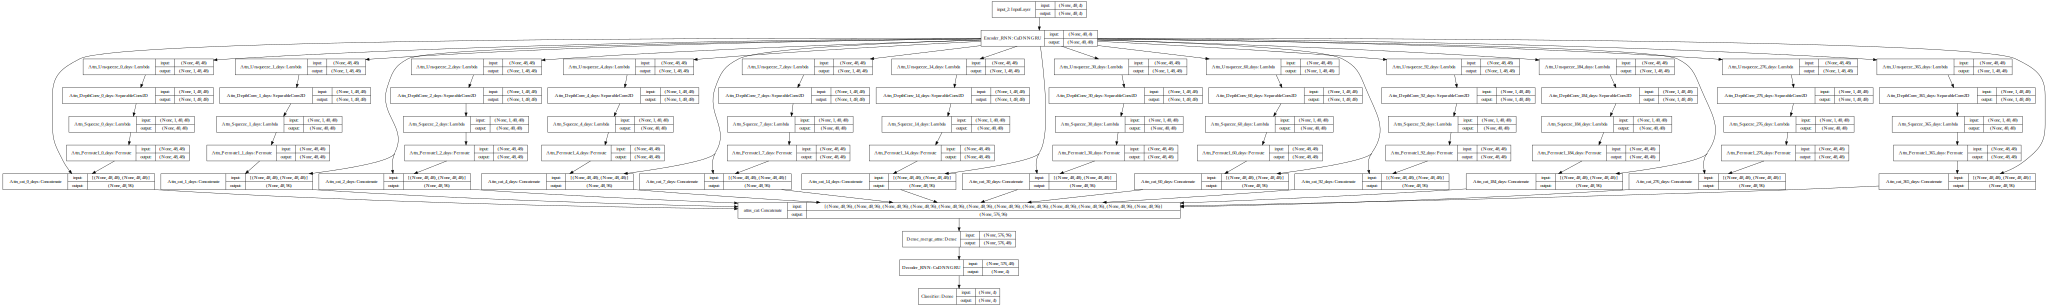

In [52]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

### Callbacks

In [53]:
from keras.callbacks import History, ModelCheckpoint, CSVLogger, EarlyStopping

In [54]:
history = History()
checkpointer = ModelCheckpoint(filepath= LOG_PATH,
                               verbose=1, save_best_only=False)
csv_logger = CSVLogger("checkpoints/" + time.strftime("%Y-%m-%d_%H%M-")+'training.log')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, verbose=1, mode='auto')

# Training

In [55]:
print(X_train.shape)

(13089, 48, 4)


# Saving RNN states

In [ ]:
model.fit(X_train, y_train,
          batch_size=bs,
          epochs=epochs,
          validation_split=0.05,
          shuffle=False,
          callbacks=[history,checkpointer,csv_logger,early_stop])

In [29]:
def get_states(model):
    return [K.get_value(s) for s,_ in model.state_updates]

def set_states(model, states):
    for (d,_), s in zip(model.state_updates, states):
        K.set_value(d, s)

In [30]:
RNNs_states = get_states(model)

# Validation

## Validation by feeding truth values

In [31]:
def plot_preds(y_truth, y_pred):
    for junction in range(4):
        plt.figure
        plt.plot(y_truth[:,junction], color = 'blue', label = 'Real traffic')
        plt.plot(y_pred[:,junction], color = 'orange', label = 'Predicted traffic')
        plt.title('Traffic Forecasting at junction %i' % (junction+1))
        plt.xlabel('Number of hours from Start')
        plt.ylabel('Traffic')
        plt.legend()
        plt.show()

### Prediction

In [32]:
set_states(model, RNNs_states)

In [33]:
y_pred = model.predict(X_test)

In [34]:
y_pred.shape

(1454, 4)

### Plot & score

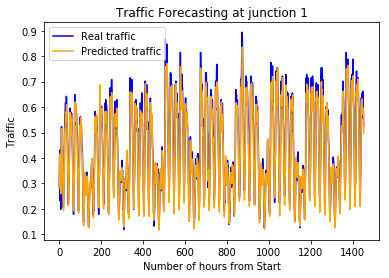

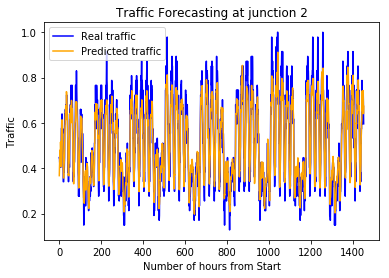

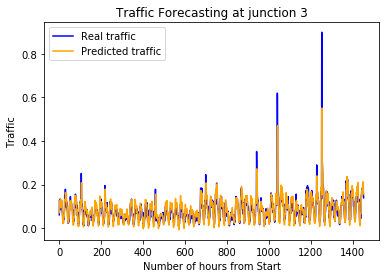

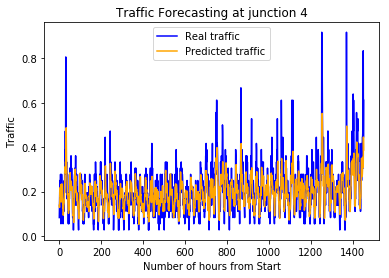

In [35]:
plot_preds(y_test, y_pred)

In [37]:
rmse(y_test, y_pred)

0.05844184420934498